In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [80]:
df = pd.read_csv('filled_missings_df.csv')

In [81]:
df.head()

,Unnamed: 0,ListingKey,ListingNumber,ListingCreationDate,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,ListingCategory (numeric),...,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Defaulted
0,0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,36,Completed,0.16516,0.1580,0.1380,0,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258,0
1,1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,36,Current,0.12016,0.0920,0.0820,2,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1,0
2,2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,36,Completed,0.28269,0.2750,0.2400,0,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41,0
3,3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,36,Current,0.12528,0.0974,0.0874,16,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158,0
4,4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,36,Current,0.24614,0.2085,0.1985,2,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20,0


In [82]:
df.columns

Index(['Unnamed: 0', 'ListingKey', 'ListingNumber', 'ListingCreationDate',
       'Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'ListingCategory (numeric)', 'BorrowerState', 'EmploymentStatus',
       'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CurrentlyInGroup',
       'DateCreditPulled', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'TotalTrades',
       'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months',
       'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable',
       'StatedMonthlyIncome', 'LoanKey', 'Loa

### All those should be droppedd if we assume that we are making a model focused on scoring clients before giving them a loan

In [83]:
cols_to_drop = ['Unnamed: 0', 'ListingKey', 'ListingNumber', 'LoanStatus', 'LoanKey', 'LoanCurrentDaysDelinquent', 'LoanMonthsSinceOrigination', 'LoanNumber',
                'MemberKey', 'LP_CustomerPayments', 'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees', 'LP_CollectionFees',
                'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss', 'LP_NonPrincipalRecoverypayments', 'LoanOriginationDate', 'LoanOriginationQuarter',
                'FirstRecordedCreditLine', 'CreditScoreRangeLower', 'CreditScoreRangeUpper']

In [84]:
df = df.drop(columns=cols_to_drop)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114805 entries, 0 to 114804
Data columns (total 41 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   ListingCreationDate                 114805 non-null  object 
 1   Term                                114805 non-null  int64  
 2   BorrowerAPR                         114805 non-null  float64
 3   BorrowerRate                        114805 non-null  float64
 4   LenderYield                         114805 non-null  float64
 5   ListingCategory (numeric)           114805 non-null  int64  
 6   BorrowerState                       114805 non-null  object 
 7   EmploymentStatus                    114805 non-null  object 
 8   EmploymentStatusDuration            114805 non-null  float64
 9   IsBorrowerHomeowner                 114805 non-null  bool   
 10  CurrentlyInGroup                    114805 non-null  bool   
 11  DateCreditPulled          

In [86]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101)

#### Binning with optbin
https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#what_is_weight_of_evidence

In [ ]:
from optbinning import OptimalBinning

y_train = train_df["Defaulted"]
X_train = train_df.drop(columns=["Defaulted"])
X_test = test_df.copy()

binning_transformers = {}
X_train_binned = pd.DataFrame()
X_test_binned = pd.DataFrame()
X_train_binned_woe = pd.DataFrame()
X_test_binned_woe = pd.DataFrame()

iv_scores = {}

for column in X_train.columns:
    # Check for dtype
    dtype = "numerical" if pd.api.types.is_numeric_dtype(X_train[column]) else "categorical"

    # fit on train
    optb = OptimalBinning(name=column, dtype=dtype, solver="cp")
    optb.fit(X_train[column], y_train)

    # Store in dict
    binning_transformers[column] = optb

    # Transform to WOE
    X_train_binned_woe[column] = optb.transform(X_train[column], metric="woe")
    X_test_binned_woe[column] = optb.transform(X_test[column], metric="woe")

    # Transform to bin edges
    X_train_binned[column] = optb.transform(X_train[column], metric="bins")
    X_test_binned[column] = optb.transform(X_test[column], metric="bins")

    # Binning table and calculating Information Value
    binning_table = optb.binning_table
    binning_table.build()
    iv_scores[column] = binning_table.iv  # calculated IV

iv_scores = {key: float(value) for key, value in iv_scores.items()}

### Feature Selection

#### Information Values

In [88]:
iv_scores

{'ListingCreationDate': 0.0,
 'Term': 0.21787231563493004,
 'BorrowerAPR': 0.31761549854015825,
 'BorrowerRate': 0.4673600461288387,
 'LenderYield': 0.44355974223585926,
 'ListingCategory (numeric)': 0.4905577648612991,
 'BorrowerState': 0.06534163128308848,
 'EmploymentStatus': 0.7383432293124282,
 'EmploymentStatusDuration': 0.21606437137850532,
 'IsBorrowerHomeowner': 0.015376850894377861,
 'CurrentlyInGroup': 0.2876375490102512,
 'DateCreditPulled': 0.0,
 'OpenCreditLines': 0.23329662128098203,
 'TotalCreditLinespast7years': 0.06874047489772878,
 'OpenRevolvingAccounts': 0.2445913272941192,
 'OpenRevolvingMonthlyPayment': 0.29242241461981117,
 'InquiriesLast6Months': 0.4297621794319071,
 'TotalInquiries': 0.38586583343696285,
 'CurrentDelinquencies': 0.28100265996741525,
 'AmountDelinquent': 0.07296320689888242,
 'DelinquenciesLast7Years': 0.08705507788261573,
 'PublicRecordsLast10Years': 0.019378897017317903,
 'PublicRecordsLast12Months': 0.0,
 'RevolvingCreditBalance': 0.16466762

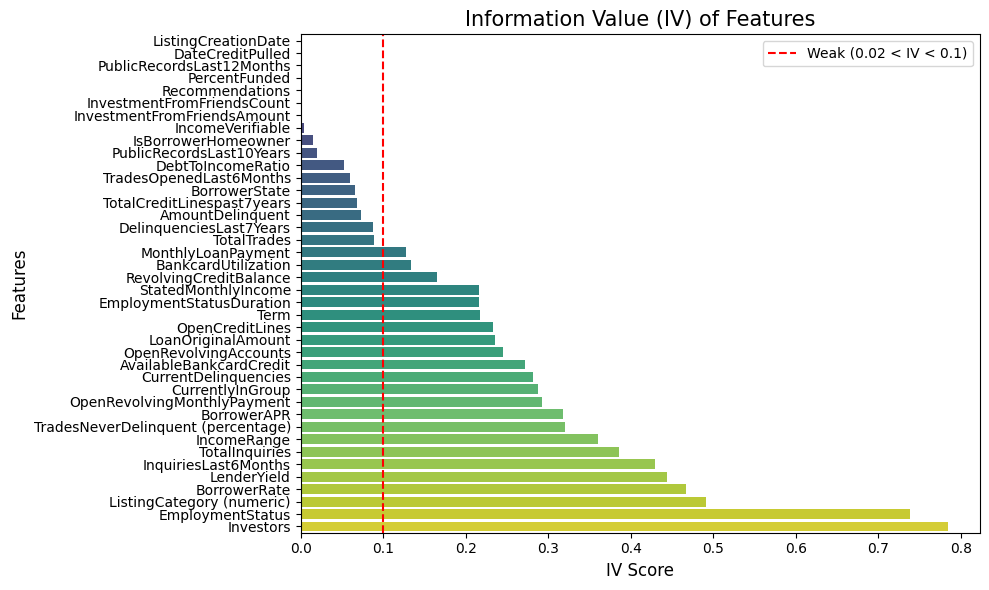

In [111]:
iv_df = pd.DataFrame.from_dict(iv_scores, orient='index', columns=['IV'])
iv_df.sort_values(by='IV', ascending=True, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='IV', y=iv_df.index, data=iv_df, palette='viridis')

plt.title('Information Value (IV) of Features', fontsize=15)
plt.xlabel('IV Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
# plt.axvline(x=0.02, color='red', linestyle='--', label='Not useful (IV < 0.02)')
plt.axvline(x=0.1, color='red', linestyle='--', label='Weak (0.02 < IV < 0.1)')
# plt.axvline(x=0.1, color='orange', linestyle='--', label='Weak (0.02 < IV < 0.1)')
# plt.axvline(x=0.3, color='yellow', linestyle='--', label='Medium (0.1 < IV < 0.3)')
# plt.axvline(x=0.5, color='green', linestyle='--', label='Strong (0.3 < IV < 0.5)')
# # plt.axvline(x=0.505, color='red', linestyle='--', label='Too high (0.5 < IV)')
plt.legend()

plt.tight_layout()
plt.show()

#### Variable predictivness

In [ ]:
# no_prediction_power = [] # to be removed
# weak_prediction_power = []
# medium_predictive_power = []
# strong_predictive_power = []
# too_big_predictive_power = [] # to be removed

# for key, value in iv_scores.items():
#     if value < 0.02:
#         no_prediction_power += [key]
#     elif value <= 0.1:
#         weak_prediction_power += [key]
#     elif value <= 0.3:
#         medium_predictive_power += [key]
#     elif value <= 0.5:
#         strong_predictive_power += [key]
#     else:
#         too_big_predictive_power += [key]

In [92]:
no_prediction_power = [] # to be removed
good_prediction_power = []

for key, value in iv_scores.items():
    if value <= 0.1:
        no_prediction_power += [key]
    else:
        good_prediction_power += [key]

In [95]:
print(*good_prediction_power, sep='\n')

Term
BorrowerAPR
BorrowerRate
LenderYield
ListingCategory (numeric)
EmploymentStatus
EmploymentStatusDuration
CurrentlyInGroup
OpenCreditLines
OpenRevolvingAccounts
OpenRevolvingMonthlyPayment
InquiriesLast6Months
TotalInquiries
CurrentDelinquencies
RevolvingCreditBalance
BankcardUtilization
AvailableBankcardCredit
TradesNeverDelinquent (percentage)
IncomeRange
StatedMonthlyIncome
LoanOriginalAmount
MonthlyLoanPayment
Investors


#### Lasso Regression for feature selection

In [103]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_binned_woe)
X_test_scaled = scaler.transform(X_test_binned_woe)

lasso = LassoCV(
    alphas=np.logspace(-3, 0, 50),
    cv=5, random_state=42, max_iter=10_000)
lasso.fit(X_train_scaled, y_train)

selected_lasso = X_train_binned_woe.columns[lasso.coef_ != 0].tolist()
print("Selected features by Lasso:")
print(*selected_lasso, sep='\n')

Selected features by Lasso:
Term
BorrowerAPR
BorrowerRate
ListingCategory (numeric)
BorrowerState
EmploymentStatus
EmploymentStatusDuration
IsBorrowerHomeowner
CurrentlyInGroup
TotalCreditLinespast7years
OpenRevolvingAccounts
OpenRevolvingMonthlyPayment
InquiriesLast6Months
TotalInquiries
CurrentDelinquencies
AmountDelinquent
DelinquenciesLast7Years
PublicRecordsLast10Years
RevolvingCreditBalance
BankcardUtilization
AvailableBankcardCredit
TotalTrades
TradesOpenedLast6Months
DebtToIncomeRatio
IncomeVerifiable
StatedMonthlyIncome
MonthlyLoanPayment
Investors


In [104]:
print(*[(x, x in good_prediction_power, iv_scores[x]) for x in selected_lasso], sep='\n')

('Term', True, 0.21787231563493004)
('BorrowerAPR', True, 0.31761549854015825)
('BorrowerRate', True, 0.4673600461288387)
('ListingCategory (numeric)', True, 0.4905577648612991)
('BorrowerState', False, 0.06534163128308848)
('EmploymentStatus', True, 0.7383432293124282)
('EmploymentStatusDuration', True, 0.21606437137850532)
('IsBorrowerHomeowner', False, 0.015376850894377861)
('CurrentlyInGroup', True, 0.2876375490102512)
('TotalCreditLinespast7years', False, 0.06874047489772878)
('OpenRevolvingAccounts', True, 0.2445913272941192)
('OpenRevolvingMonthlyPayment', True, 0.29242241461981117)
('InquiriesLast6Months', True, 0.4297621794319071)
('TotalInquiries', True, 0.38586583343696285)
('CurrentDelinquencies', True, 0.28100265996741525)
('AmountDelinquent', False, 0.07296320689888242)
('DelinquenciesLast7Years', False, 0.08705507788261573)
('PublicRecordsLast10Years', False, 0.019378897017317903)
('RevolvingCreditBalance', True, 0.16466762313869834)
('BankcardUtilization', True, 0.13379

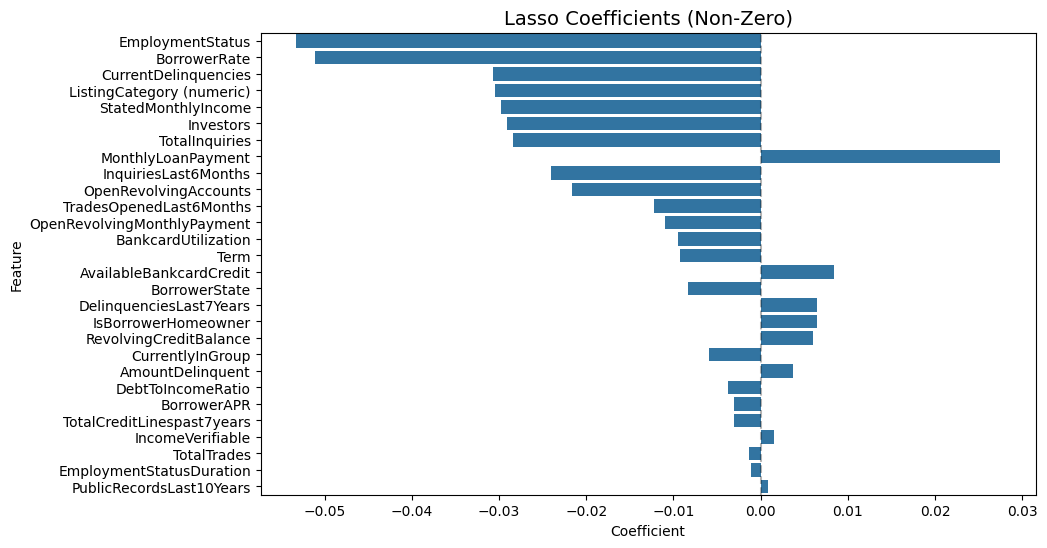

In [105]:
coef_df = pd.DataFrame({
    'Feature': X_train_binned_woe.columns,
    'Coefficient': lasso.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df[coef_df['Coefficient'] != 0])
plt.title('Lasso Coefficients (Non-Zero)', fontsize=14)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.show()

In [106]:
print("Optimal lambda (alpha):", lasso.alpha_)

Optimal lambda (alpha): 0.001


In [112]:
selected_iv = good_prediction_power

final_features = list(set(selected_iv) & set(selected_lasso))
print("Final selected features (IV + Lasso):")
print(*final_features, sep='\n')
# print(*[(x, iv_scores[x]) for x in final_features], sep='\n')

Final selected features (IV + Lasso):
ListingCategory (numeric)
CurrentDelinquencies
OpenRevolvingAccounts
BorrowerRate
OpenRevolvingMonthlyPayment
InquiriesLast6Months
RevolvingCreditBalance
EmploymentStatus
CurrentlyInGroup
Investors
StatedMonthlyIncome
EmploymentStatusDuration
AvailableBankcardCredit
BankcardUtilization
TotalInquiries
Term
MonthlyLoanPayment
BorrowerAPR


In [113]:
final_iv_scores = {key: iv_scores[key] for key in final_features}

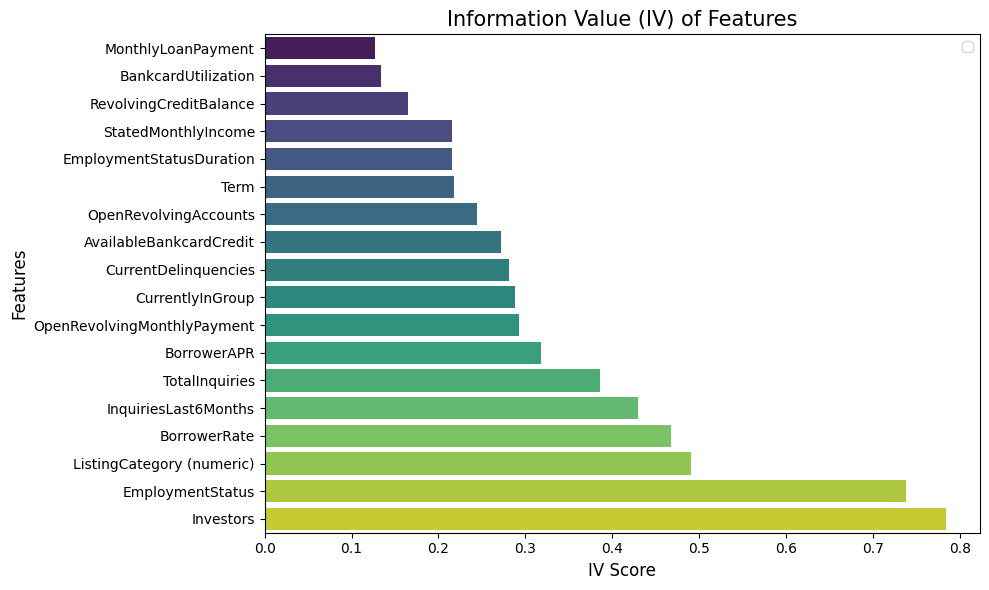

In [114]:
final_iv_df = pd.DataFrame.from_dict(final_iv_scores, orient='index', columns=['IV'])
final_iv_df.sort_values(by='IV', ascending=True, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='IV', y=final_iv_df.index, data=final_iv_df, palette='viridis')

plt.title('Information Value (IV) of Features', fontsize=15)
plt.xlabel('IV Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
# plt.axvline(x=0.1, color='red', linestyle='--', label='Weak (0.02 < IV < 0.1)')
plt.legend()

plt.tight_layout()
plt.show()

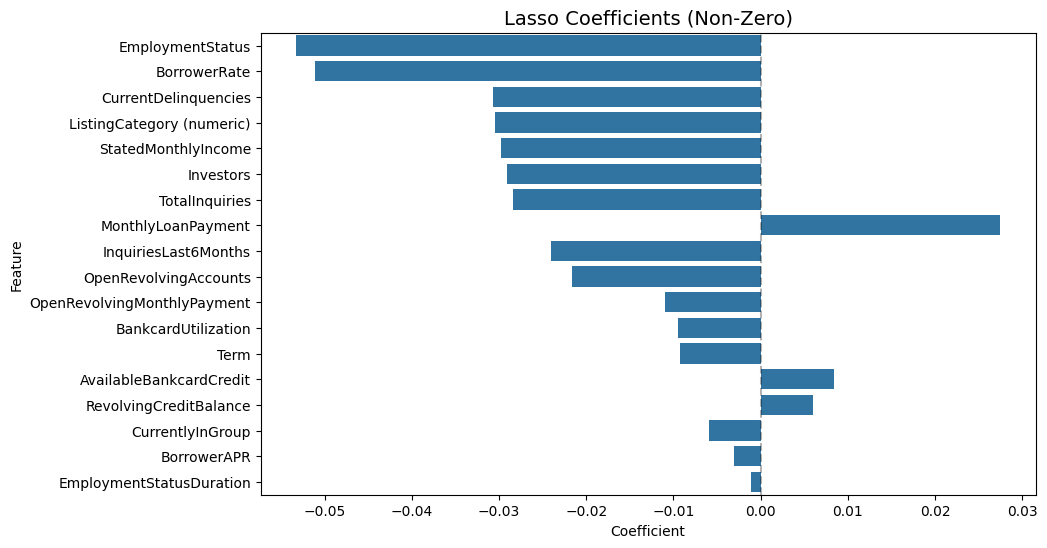

In [117]:
final_coef = coef_df[coef_df['Feature'].isin(final_features)]

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=final_coef)
plt.title('Lasso Coefficients (Non-Zero)', fontsize=14)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.show()

### TODO: 
1. *Information Value - done*
2. Lasso regression
3. Maybe random forest and based on feature importance
4. Also maybe combine 1 and 2 and 3, so if IV is high (maybe above ~ 0.03) and coefficient non zero and decent feature importance 